In [1]:
import sys
import time
import datetime
from train import *
from params import TrainingParams

def time_remaining(params, batch):
    time_remaining = 0
    total_batches = (params.total_train_sample/params.batch_size)*params.num_epoch
    
    if params.initial_batch is None:
        params.initial_batch = batch
        params.last_time = time.perf_counter()
    else:
        cur_time = time.perf_counter()
        elapsed = cur_time - params.last_time
        params.last_time = cur_time
        batch_remaining = total_batches - (batch-params.initial_batch)
        time_remaining = int(batch_remaining*elapsed)
    return time_remaining, (total_batches+params.initial_batch-1)

def report_loss_simple(params, batch, total_cost, content_cost, style_cost):
    t, tb = time_remaining(params, batch)
    sys.stdout.write("\r")
    sys.stdout.write("Batch %i/%i. Total Loss: %s. ETA %s         " % (batch, tb, str(total_cost), str(datetime.timedelta(seconds=t))))
    sys.stdout.flush()

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
Using TensorFlow backend.


In [5]:
params = TrainingParams()
# aws
# params.train_path='/home/ubuntu/work/data/unlabeled2017/*.jpg'
# mbp
# params.train_path='/Users/paul/Work/ai/images/val2017/*.jpg'
# azure
# params.train_path = '/home/paul/src/images/train2017/*.jpg'
# tf
#params.train_path = ['/Users/paul/Work/ai/images/tf/%i.tfr' % (i) for i in range(2)]
# aws tf
params.train_path = ['/home/ubuntu/work/images/train/%i.tfr' % (i) for i in range(30)]
params.style_path='data/wave.jpg'
params.batch_size = 4
params.num_epoch = 1
params.learn_rate = 0.0001
params.total_train_sample = 4*15000
# mosaic
# params.style_weight = 20.0
# waves
params.style_weight = 100.0
params.content_weight = 1.0
params.tv_weight=0.0
params.save_path='models/waves'
params.summary_step=50
params.read_thread=4

In [ ]:
params.last_time = None
params.initial_batch = None
train(params, report_fn=report_loss_simple, start_new=True)

Evaluating Target Style...
Defining Input Pipeline...
Building Model...
Defining Losses...
Starting...
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from models/waves/model.ckpt-15223
INFO:tensorflow:Saving checkpoints for 15224 into models/waves/model.ckpt.
Batch 15323/30223. Total Loss: 157892.0. ETA 0:56:53         INFO:tensorflow:global_step/sec: 4.18531
Batch 15423/30223. Total Loss: 154746.0. ETA 0:56:24         INFO:tensorflow:global_step/sec: 4.36599
Batch 15523/30223. Total Loss: 158743.0. ETA 0:56:12         INFO:tensorflow:global_step/sec: 4.36903
Batch 15623/30223. Total Loss: 178178.0. ETA 0:56:02         INFO:tensorflow:global_step/sec: 4.36546
Batch 15723/30223. Total Loss: 190156.0. ETA 0:55:17         INFO:tensorflow:global_step/sec: 4.36828
Batch 15823/30223. Total Loss: 174463.0. ETA 0:55:01         INFO:tensorflow:global_step/sec: 4.36966
Batch 15923/30223. Total Loss: 168706.0. ETA 0:54:40         INFO:tensorflow:global_step/sec: 

In [2]:
# needed for style an image
import matplotlib.pyplot as plt
from IPython import display
%matplotlib inline
from params import TransferParams
from pipeline import *
import numpy as np

def transfer(path, out_path=None):
    # init    
    tf.reset_default_graph()
    sess = tf.InteractiveSession()
    
    input_image = process_img(path, crop=False).eval()
    input_shape = [1] + list(input_image.shape)
    
    # make the model
    input_placeholder = tf.placeholder(dtype=tf.float32, shape=input_shape, name='input_images')
    gen = SpriteGenerator(input_placeholder, 'SpriteGenerator')
    
    # restore
    saver = tf.train.Saver()
    saver.restore(sess, 'models/waves/model.ckpt-15223')
    
    # generate and write out
    output = sess.run(gen.output, feed_dict={input_placeholder:np.stack([input_image])})
    plt.imshow(output[0]/255.)  
    
    if out_path is not None:
        output = tf.image.encode_jpeg(output[0])  
        write = tf.write_file(out_path, output)
        sess.run(write)
        print('Generate Done.')

INFO:tensorflow:Restoring parameters from models/waves/model.ckpt-15223
Generate Done.


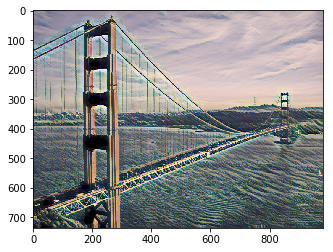

In [4]:
transfer('data/golden_gate.jpg', 'data/generated.jpg')